# Поиск по изображениям для фотохостинга

## Содержание

* [Описание проекта](#chapter_1)
    * [Описание проекта](#chapter_1_1)
    * [Цель и задачи](#chapter_1_2)
    * [Юридические ограничения](#chapter_1_3)
    * [Описание данных](#chapter_1_4)
* [Импорт библиотек и настройки](#chapter_2)
* [Загрузка и общий обзор данных](#chapter_3)
    * [Загрузка данных](#chapter_3_1)
    * [Общий обзор данных](#chapter_3_2)
    * [Промежуточный вывод](#chapter_3_3)
* [Исследовательский анализ данных](#chapter_4)
    * [Анализ датасета train_dataset](#chapter_4_1)
    * [Анализ датасета crowd_annotations](#chapter_4_2)
    * [Анализ датасета expert_annotations](#chapter_4_3)
    * [Анализ датасета test_queries](#chapter_4_4)
    * [Проверка пересечения датасетов](#chapter_4_5)
    * [Графический анализ](#chapter_4_6)
    * [Агрегация оценок](#chapter_4_7)
    * [Промежуточный вывод](#chapter_4_8)
* [Подготовка данных](#chapter_5)
    * [Проверка данных на соответствие юридическим требованиям](#chapter_5_1)
    * [Векторизация текстов](#chapter_5_2)
    * [Векторизация изображений](#chapter_5_3)
    * [Промежуточный вывод](#chapter_5_4)
* [Обучение моделей](#chapter_6)
    * [Разделение на тренировочную и валидационную выборки](#chapter_6_1)
    * [Бейзлайн модель и модели классического ML](#chapter_6_2)
    * [Модель на основе нейросети](#chapter_6_3)
    * [Промежуточный вывод](#chapter_6_4)
* [Тестирование лучшей модели](#chapter_7)
    * [Формирование тестовых функций](#chapter_7_1)
    * [Проверка на описаниях из тестового набора](#chapter_7_2)
    * [Использование предобученной модели CLIP](#chapter_7_3)
    * [Промежуточный вывод](#chapter_7_4)
* [Общий вывод](#chapter_8)

<a id="chapter_1"></a>
## Описание проекта

<a id="chapter_1_1"></a>
### Описание проекта

В фотохостинге для профессиональных фотографов пользователи размещают свои фотографии и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Нам поручено провести эксперимент по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой. Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

На основе лучшей модели можно будет собрать предварительную версию продукта, которую мы продемонстрируем руководителю компании.

<a id="chapter_1_2"></a>
### Цель и задачи

**Заказчик исследования:** фотохостинг для профессиональных фотографов.

**Цель:** разработка PoC для поиска референсных фотографий для фотографов.

**Задачи (этапы) исследования:**
1. Провести загрузку и исследовательский анализ данных.
2. Подготовить данные к обучению модели:
- создать список слов, которые могут попадать под юридические ограничения;
- исключить из обучающего датасета пары, которые могут попадать под юридические ограничения;
- сделать векторизацию текстового описания;
- сделать векторизацию изображений с использованием модели ResNet18;
- описать получившиеся пары векторов с точки зрения их размерностей.
3. Обучить модель:
- создать модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов;
- выбрать метрику для сравнения точности различных моделей;
- обучить несколько моделей. В качестве моделей обязательно нужно рассмотреть линейную регрессию и полносвязные нейронные сети.
4. Провести тестирование модели и демонстрацию ее работы:
- провести тестирование лучшей модели на тестовых данных;
- создать функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики. Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.
- с помощью написанной функции протестировать работу модели на нескольких текстовых описаниях.
5. Сделать общий вывод по работе.

<a id="chapter_1_3"></a>
### Юридические ограничения

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

В сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

⎢ This image is unavailable in your country in compliance with local laws.

Однако в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

<a id="chapter_1_4"></a>
### Описание данных

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

<a id="chapter_2"></a>
## Импорт библиотек и настройки

In [ ]:
import pandas as pd
import numpy as np
import random

import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

import torch
import torch.nn as nn

from torchvision import transforms
import torchvision.models as models

import transformers

import copy

from sentence_transformers import SentenceTransformer, util
import glob

In [ ]:
PATH = '...'

In [ ]:
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BLOCK_WORDS = [
    'kid', 'kids',
    'baby', 'babies',
    'child', 'children',
    'boy', 'boys',
    'girl', 'girls',
    'toddler', 'toddlers',
    'teenage', 'teenager', 'teenagers',
    'young', 'youngster'
]

<a id="chapter_3"></a>
## Загрузка и общий обзор данных

<a id="chapter_3_1"></a>
### Загрузка данных

Загрузим zip-архив и разархивируем его в локальную папку.

In [ ]:
!wget -N ...
!unzip -uq ...

Загрузим файлы в датафреймы.

In [ ]:
df_train_dataset = pd.read_csv(PATH + 'train_dataset.csv')
df_crowd_annotations = pd.read_csv(PATH + 'CrowdAnnotations.tsv', sep='\t',
                                   names=['image', 'query_id', 'positive_share', 'positive_count', 'negative_count'])
df_expert_annotations = pd.read_csv(PATH + 'ExpertAnnotations.tsv', sep='\t',
                                    names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
df_test_queries = pd.read_csv(PATH + 'test_queries.csv', sep='|', index_col=[0])
df_test_images = pd.read_csv(PATH + 'test_images.csv', sep='|')


<a id="chapter_3_2"></a>
### Общий обзор данных

In [ ]:
dataframes = {
    'df_train_dataset': df_train_dataset,
    'df_crowd_annotations': df_crowd_annotations,
    'df_expert_annotations': df_expert_annotations,
    'df_test_queries': df_test_queries,
    'df_test_images': df_test_images
}

for name, df in dataframes.items():
    print('Датафрейм:', name)
    df.info()
    df.head()
    print('Число дубликатов:', df.duplicated().sum())
    print('\n')

Датафрейм: df_train_dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
Число дубликатов: 0


Датафрейм: df_crowd_annotations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   positive_share  47830 non-null  float64
 3   positive_count  47830 non-null  int64  
 4   negative_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
Число дубликатов: 0


Датафрейм: df_expert_annotations
<class 'pandas.core.frame.Data

В датафреймах представлено:
- 5822 тренировочных описания;
- 47830 пользовательских оценок соответствия описаний;
- 5822 экспертные оценки соответствия описаний;
- 500 тестовых описаний;
- 100 тестовых картинок.

Пропуски и полные дубликаты отсутствуют во всех датафреймах.

<a id="chapter_3_3"></a>
### Промежуточный вывод

Мы провели загрузку и общий обзор данных, в ходе которого установили, что пропуски и полные дубликаты отсутствуют во всех датафреймах.

<a id="chapter_4"></a>
## Исследовательский анализ данных

<a id="chapter_4_1"></a>
### Анализ датасета train_dataset

Почитаем число уникальных изображений и описаний.

In [ ]:
print('Число уникальных изображений:', df_train_dataset['image'].nunique())
print('Число уникальных описаний:',df_train_dataset['query_id'].nunique())

Число уникальных изображений: 1000
Число уникальных описаний: 977


Число уникальных описаний меньше числа изображений. Это означает, что для некоторых изображений использованы неподходящие описания (от других изображений).

Рассмотрим такие случаи подробнее.

In [ ]:
df_train_dataset[df_train_dataset['query_id'].duplicated()].head(10)

image                     query_id  \
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   

                                           query_text  
1   A young child is wearing blue goggles and sitt...  
2   A young child is wearing blue goggles and sitt...  
3   A young child is wearing blue goggles and sitt...  
4   A young child is wearing blue goggles and sitt...  
5   A young child is wearing blue goggles and sitt...  
6   A young child is wearing blue goggles and sitt...  
7   A young child is wearing blue goggles and sitt...  
8   A young child is wearing blue goggles and sitt...  
9   A young child is wearing blue goggles and sitt...  
10  A young child is wearing blue goggles and sitt...

Действительно, мы видим, что в ряде случаев первая часть id описания не совпадает с id изображения: одно и то же описание используется для разных изображений.

Рассмотрим, у скольких записей совпадают id описания и изображения.

In [ ]:
len(df_train_dataset[df_train_dataset['query_id'].apply(lambda x: x[:-2]) == df_train_dataset['image']])

158

Таких совпадений всего 158, что значительно меньше размера датасета. Примем это во внимание, но пока оставим эти данные как есть (ведь для нас важно не само описание, а его соответствие изображению).

Выведем облако слов, чтобы продемонстрировать наиболее часто встречающиеся слова.

In [ ]:
def clear_text(text):
    stop_words = set(stopwords.words('english'))
    cleared_text = re.sub(r'[^A-Za-z \n]', '', text).lower()
    cleared_text = [i for i in cleared_text.split() if i not in stop_words]
    cleared_text = ' '.join(cleared_text)
    return cleared_text

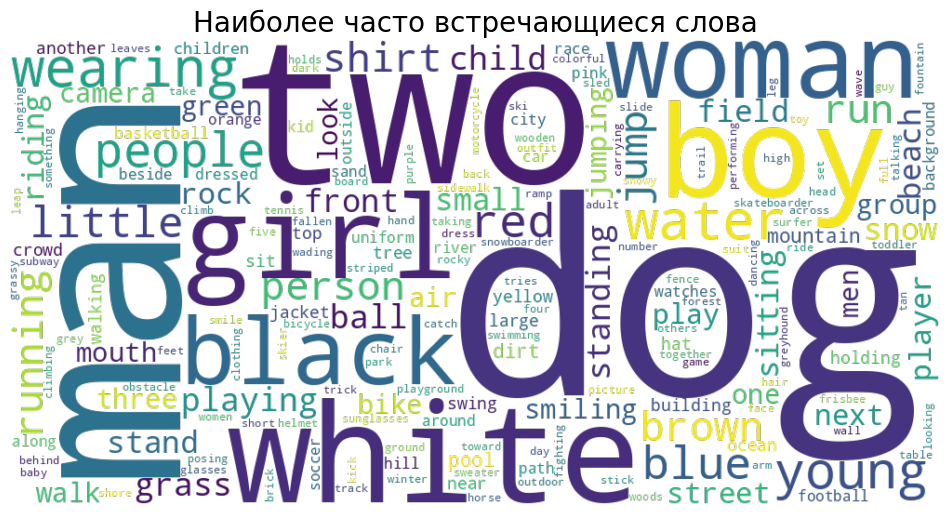

In [ ]:
cleared_text = ' '.join(df_train_dataset['query_text'].apply(clear_text))
wordcloud = WordCloud(collocations=False, background_color=None,
                      mode='RGBA', width=1000, height=500).generate(cleared_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud , interpolation='bilinear')
plt.axis('off')
plt.title('Наиболее часто встречающиеся слова', fontsize=20)
plt.show()

Мы видим, что достаточно часто в описаниях встречаются слова, соответствующие юридическим ограничениям (girl, boy и т.д.).

<a id="chapter_4_2"></a>
### Анализ датасета crowd_annotations

Почитаем число уникальных описаний.

In [ ]:
print('Число уникальных описаний:',df_crowd_annotations['query_id'].nunique())

Число уникальных описаний: 1000


Рассмотрим распределение доли людей, подтвердивших, что описание соответствует изображению.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


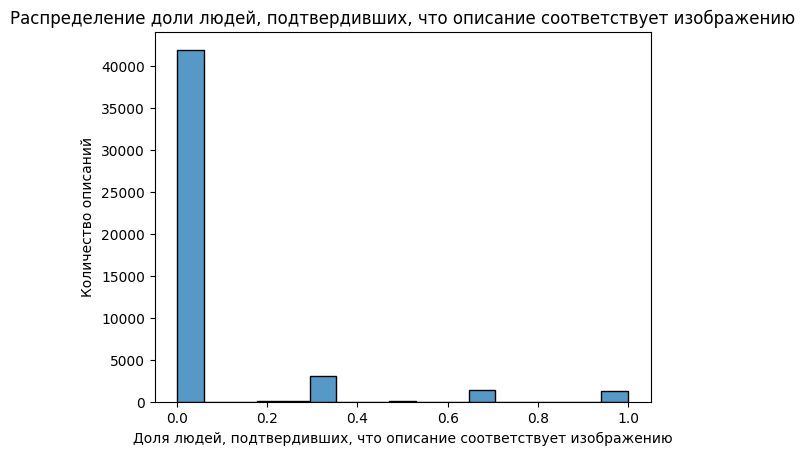

In [ ]:
sns.histplot(data=df_crowd_annotations, x='positive_share')\
.set(title='Распределение доли людей, подтвердивших, что описание соответствует изображению',
     xlabel='Доля людей, подтвердивших, что описание соответствует изображению',
     ylabel='Количество описаний');

По большинству описаний оценки пользователей свидетельствуют о несоответствии изображению (что не удивительно, учитывая что только 158 описаний имеют id, соответствующее изображению). То, что положительный класс представлен слабо, - достаточно большой минус для последующего обучения нашей модели.

<a id="chapter_4_3"></a>
### Анализ датасета expert_annotations

Почитаем число уникальных описаний.

In [ ]:
print('Число уникальных описаний:',df_expert_annotations['query_id'].nunique())

Число уникальных описаний: 977


Рассмотрим распределение средней оценки от экспертов.

In [ ]:
df_expert_annotations['mean_expert_score'] = df_expert_annotations[['expert_1', 'expert_2', 'expert_3']].mean(axis=1)/4

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


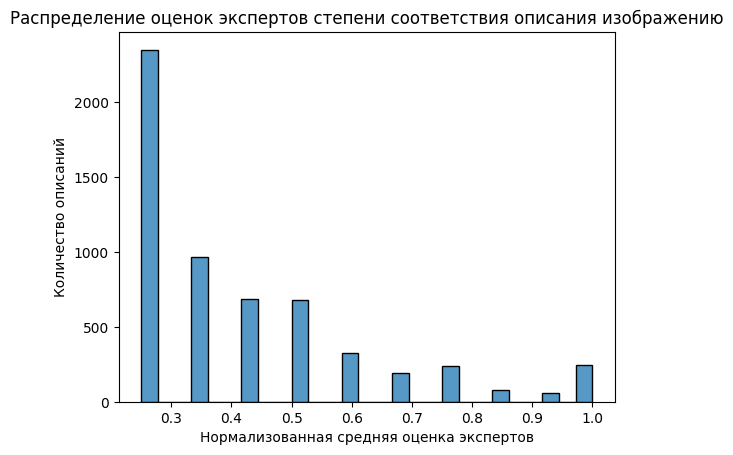

In [ ]:
sns.histplot(data=df_expert_annotations, x='mean_expert_score')\
.set(title='Распределение оценок экспертов степени соответствия описания изображению',
     xlabel='Нормализованная средняя оценка экспертов',
     ylabel='Количество описаний');

В оценках экспертов дисбаланс классов меньше, чем в оценках пользователей. Целесообразно как основную оценку использовать именно оценку экспертов, а оценку пользователей - там, где экспертные оценки отсутствуют.

<a id="chapter_4_4"></a>
### Анализ датасета test_queries

Почитаем число уникальных изображений и описаний.

In [ ]:
print('Число уникальных изображений:', df_test_queries['image'].nunique())
print('Число уникальных описаний:',df_test_queries['query_id'].nunique())

Число уникальных изображений: 100
Число уникальных описаний: 500


Здесь на каждое изображение приходится по 5 описаний. Все описания уникальны.

<a id="chapter_4_5"></a>
### Проверка пересечения датасетов

Проверим пересечение датасетов с оценками пользователей и экспертов (по query_id).

In [ ]:
expert_annotations_set = set(df_expert_annotations['query_id'])
crowd_annotations_set = set(df_crowd_annotations['query_id'])
print('Число пересекающихся описаний:', len(expert_annotations_set & crowd_annotations_set))

Число пересекающихся описаний: 977


Для всех оценок экспертов есть соответствующие им пользовательские, но для некоторых описаний есть только пользовательские оценки.

Проверим пересечение тренировочного и тестового датасетов (по image и query_text).

In [ ]:
train_set = set(df_train_dataset['image'])
test_set = set(df_test_queries['image'])
print('Число пересекающихся изображений:', len(train_set & test_set))

Число пересекающихся изображений: 0


In [ ]:
train_set = set(df_train_dataset['query_text'])
test_set = set(df_test_queries['query_text'])
print('Число пересекающихся описаний:', len(train_set & test_set))

Число пересекающихся описаний: 0


Пересекающиеся изображения и описания отсутствуют.

<a id="chapter_4_6"></a>
### Графический анализ

Выведем по 10 случайных изображений из тренировочного и тестового наборов.

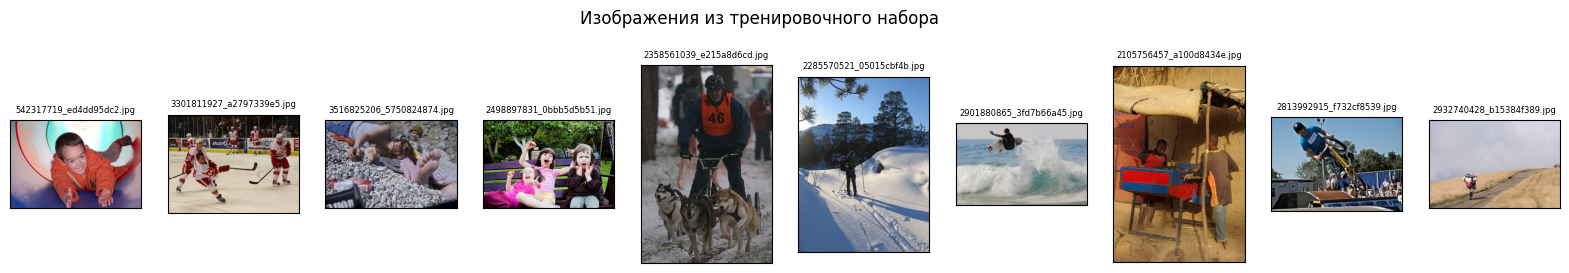

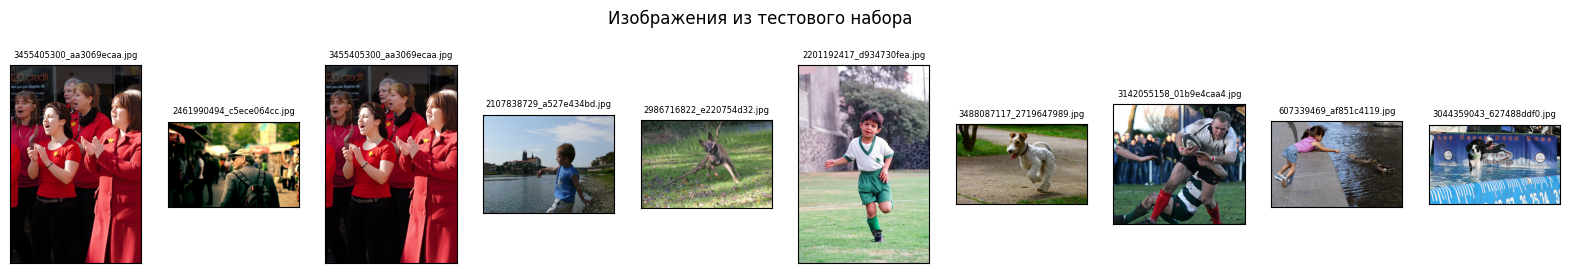

In [ ]:
def show_images(image_names, sup_title, titles, set):
    image_names = list(image_names)
    titles = list(titles)
    num_images = len(image_names)
    fig = plt.figure(figsize=(num_images*2,10))
    fig.tight_layout()
    fig.suptitle(sup_title, y=0.65)
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i+1)
        ax.set_title(titles[i], size=6)
        image = Image.open(PATH + set + '/' + image_names[i])
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

num_images = 10
_df = df_train_dataset.sample(num_images)
show_images(_df['image'], 'Изображения из тренировочного набора', _df['image'], 'train_images')
_df = df_test_queries.sample(num_images)
show_images(_df['image'], 'Изображения из тестового набора', _df['image'], 'test_images')

Изображения имеют разный размер, перед использованием в моделях их надо будет привести к единому размеру.

<a id="chapter_4_7"></a>
### Агрегация оценок

Объединим экспертные и пользовательские оценки с использованием следующего подхода:
- для каждого описания берется средняя оценка трех экспертов;
- для каждой пары "изображение-описание" берется экспертная оценка, если она отсутсвует - оценка пользователей (как доля положительных оценок).

In [ ]:
df_aggregated_scores = pd.merge(df_expert_annotations, df_crowd_annotations, how='outer', on=['image', 'query_id'])

df_aggregated_scores['aggregate_score'] = np.where(
    ~np.isnan(df_aggregated_scores['mean_expert_score']),
    df_aggregated_scores['mean_expert_score'],
    df_aggregated_scores['positive_share']
)

df_aggregated_scores.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       NaN       NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       NaN       NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       NaN       NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2       NaN       NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2       NaN       NaN   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2       NaN       NaN   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2       NaN       NaN   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2       NaN       NaN   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2       NaN       NaN   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2       NaN       NaN   

   expert_3  mean_expert_score  positive_share  positive_count  \
0       NaN                NaN        1.000000             3.0   
1       NaN                NaN        0.000000             0.0   
2       NaN                NaN        0.000000             0.0   
3       NaN                NaN        0.000000             0.0   
4       NaN                NaN        0.000000             0.0   
5       NaN                NaN        0.000000             0.0   
6       NaN                NaN        0.000000             0.0   
7       NaN                NaN        0.333333             1.0   
8       NaN                NaN        0.000000             0.0   
9       NaN                NaN        0.000000             0.0   

   negative_count  aggregate_score  
0             0.0         1.000000  
1             3.0         0.000000  
2             3.0         0.000000  
3             3.0         0.000000  
4             3.0         0.000000  
5             3.0         0.000000  
6             3.0         0.000000  
7             2.0         0.333333  
8             3.0         0.000000  
9             3.0         0.000000

Построим распределение агрегированных оценок.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


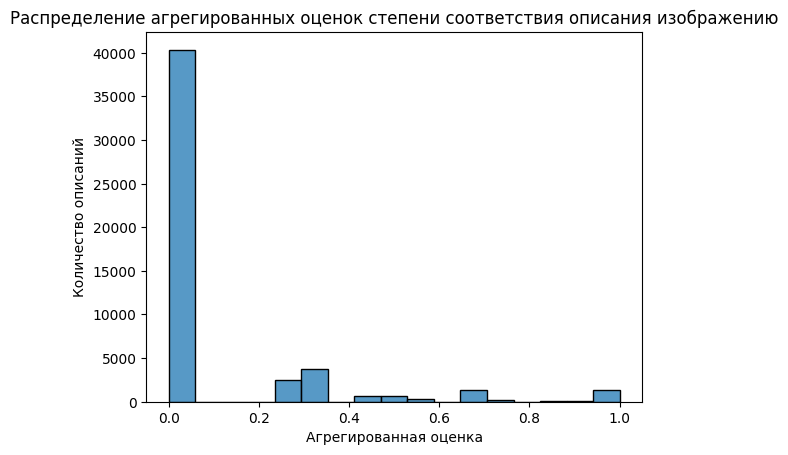

In [ ]:
sns.histplot(data=df_aggregated_scores, x='aggregate_score')\
.set(title='Распределение агрегированных оценок степени соответствия описания изображению',
     xlabel='Агрегированная оценка',
     ylabel='Количество описаний');

С учетом того, что основная доля оценок приходится на пользовательские, распределение ближе к тому, что мы видели при анализе соответствующего датасета.

Сформируем тренировочный датасет из датасета с оценками и датасета с описаниями.

In [ ]:
df_queries = df_train_dataset[['query_id', 'query_text']].drop_duplicates()

df_train = pd.merge(df_aggregated_scores[['image', 'query_id', 'aggregate_score']], df_queries, how='left', on=['query_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            51323 non-null  object 
 1   query_id         51323 non-null  object 
 2   aggregate_score  51323 non-null  float64
 3   query_text       50214 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


Для некоторых query_id отсутствует текст описания. Удалим такие записи.

In [ ]:
df_train = df_train.dropna()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            50214 non-null  object 
 1   query_id         50214 non-null  object 
 2   aggregate_score  50214 non-null  float64
 3   query_text       50214 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


<a id="chapter_4_8"></a>
### Промежуточный вывод

В ходе исследовательского анализа установлено:
- число уникальных описаний меньше числа изображений;
- в описаниях часто встречаются слова, соответствующие юридическим ограничениям;
- оценки соответствия описаний не сбалансированы: более представлен отрицательный класс (в большей степени - оценках пользователей, в меньшей – в оценках экспертов);
- оценки экспертов более надежны, поэтому для формирования агрегированной оценки мы использовали в первую очередь их, а там, где они отсутствуют – оценки пользователей;
- изображения имеют разный формат;
- пересекающиеся изображения и описания в тренировочном и тестовом наборах отсутствуют;
- для некоторых query_id отсутствовали тексты описания, мы удалили такие записи.

<a id="chapter_5"></a>
## Подготовка данных

<a id="chapter_5_1"></a>
### Проверка данных на соответствие юридическим требованиям

Добавим к датасету с уникальными описаниями метку, показывающую наличие "стоп-слов", нарушающих юридические требования.

In [ ]:
def add_mark(row):
    cleared_text = clear_text(row['query_text'])
    if [i for i in cleared_text.split() if i in BLOCK_WORDS]:
        row['block_mark'] = 1
    else:
        row['block_mark'] = 0

    return row

df_queries = df_queries.apply(add_mark, axis=1)
df_queries.head(10)

query_id  \
0   2549968784_39bfbe44f9.jpg#2   
12  2718495608_d8533e3ac5.jpg#2   
22  3181701312_70a379ab6e.jpg#2   
27  3207358897_bfa61fa3c6.jpg#2   
31  3286822339_5535af6b93.jpg#2   
38  3360930596_1e75164ce6.jpg#2   
44  3545652636_0746537307.jpg#2   
59   434792818_56375e203f.jpg#2   
72  1425069308_488e5fcf9d.jpg#2   
82  1714316707_8bbaa2a2ba.jpg#2   

                                           query_text  block_mark  
0   A young child is wearing blue goggles and sitt...           1  
12  A girl wearing a yellow shirt and sunglasses s...           1  
22    A man sleeps under a blanket on a city street .           0  
27  A woman plays with long red ribbons in an empt...           0  
31         Chinese market street in the winter time .           0  
38  A soccer ball is above the head of a man weari...           0  
44  A young boy dressed in a red uniform kicks the...           1  
59  A man and woman look back at the camera while ...           0  
72  A white dog jumps to catch a blue ball in a li...           0  
82       A little boy shakes the snow off of a tree .           1

Учитывая, что query_id содержит название изображения, создадим список изображений, "нарушающих" юридические правила.

In [ ]:
images_violation = df_queries[df_queries['block_mark']==1]['query_id'].apply(lambda x: x[:-2])
print('Число изображений, "нарушающих" юридические правила:', len(set(images_violation)))

Число изображений, "нарушающих" юридические правила: 303


Выведем 10 случайных изображений, "нарушающих" юридические правила.

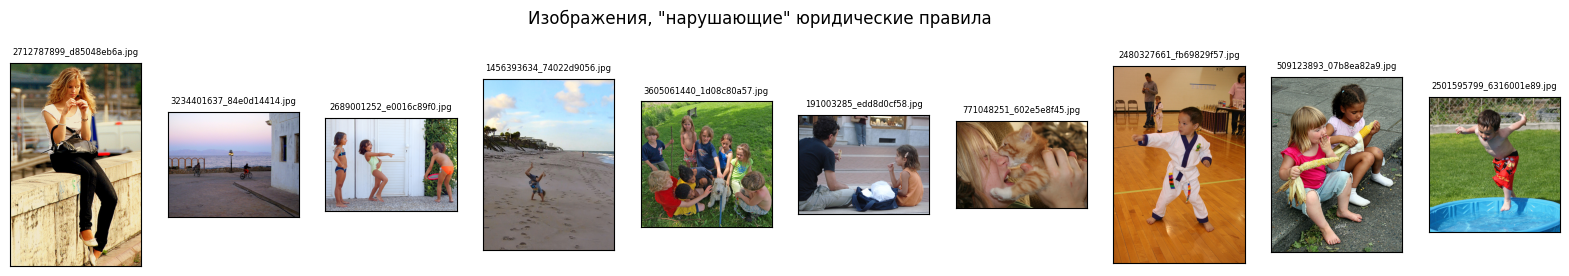

In [ ]:
num_images = 10
_df = images_violation.sample(num_images, random_state = RANDOM_STATE)
show_images(_df, 'Изображения, "нарушающие" юридические правила', _df, 'train_images')

Удалим записи с этими изображениями из тренировочного датасета.

In [ ]:
df_train_clear = df_train.query('image not in @images_violation').copy()
df_train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35139 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            35139 non-null  object 
 1   query_id         35139 non-null  object 
 2   aggregate_score  35139 non-null  float64
 3   query_text       35139 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.3+ MB


<a id="chapter_5_2"></a>
### Векторизация текстов

Для векторизации текстов используем модель BERT.

In [ ]:
model_name = 'bert-base-cased'

In [ ]:
notebook.tqdm.pandas()

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
text_model = transformers.BertModel.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
def get_text_embeddings(text, model, tokenizer, silent=False):

    max_len = 512 # для предобученной модели это максимальная длина токена

    if silent:
        tokenized = text.apply(
            lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=max_len)
        )
    else:
        tokenized = text.progress_apply(
            lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=max_len)
        )

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)

    batch_size = 16
    embeddings = []

    if silent:
        rng = range(padded.shape[0] // batch_size + 1)
    else:
        rng = notebook.tqdm(range(padded.shape[0] // batch_size + 1))

    for i in rng:
        min = batch_size*i
        max = batch_size*(i+1)
        if max > padded.shape[0]:
            max = padded.shape[0]
        batch = torch.LongTensor(padded[min:max]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[min:max]).to(device)

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())

    return np.concatenate(embeddings)

In [ ]:
_df = df_train_clear[['query_id', 'query_text']].drop_duplicates()
_df['text_embedding'] = list(get_text_embeddings(_df['query_text'], text_model, tokenizer))

df_train_clear = pd.merge(df_train_clear, _df, how='left', on=['query_id', 'query_text'])

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
df_train_clear.head()

image                     query_id  aggregate_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

                                          query_text  \
0  A woman is signaling is to traffic , as seen f...   
1          A boy in glasses is wearing a red shirt .   
2   A young boy holds onto a blue handle on a pier .   
3  A woman wearing black clothes , a purple scarf...   
4  An older woman with blond hair rides a bicycle...   

                                      text_embedding  
0  [-0.026061442, -0.108095795, 0.17990322, 0.011...  
1  [-0.046745278, -0.055341233, 0.20029381, 0.011...  
2  [0.20661694, 0.060657393, 0.075457, 0.05671436...  
3  [-0.14163017, 0.16420963, 0.156677, 0.07987247...  
4  [0.08144968, 0.17841187, 0.092687674, 0.058616...

<a id="chapter_5_3"></a>
### Векторизация изображений

Для векторизации изображений используем ResNet-18.

In [ ]:
image_model = models.resnet18(weights='IMAGENET1K_V1')

for param in image_model.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Рассмотрим слои.

In [ ]:
print(list(image_model.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

Требуется удалить последний слой (линейный).

In [ ]:
modules = list(image_model.children())[:-1]
image_model = nn.Sequential(*modules).to(device)
image_model.eval();

In [ ]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm
])

In [ ]:
def get_image_embeddings(images, model, set, silent=False):
    embeddings = []

    if silent:
        rng = images
    else:
        rng = notebook.tqdm(images)

    for image in rng:
        img = Image.open(PATH + set + '/' + image).convert('RGB')
        image_tensor = preprocess(img).to(device).unsqueeze(0)
        output_tensor = model(image_tensor).flatten()
        embeddings.append(output_tensor.to('cpu').numpy())

    return embeddings

In [ ]:
_df = pd.DataFrame(df_train_clear['image'].drop_duplicates())
_df['image_embedding'] = get_image_embeddings(_df['image'], image_model, 'train_images')
df_train_clear = pd.merge(df_train_clear, _df, how='left', on=['image'])

  0%|          | 0/697 [00:00<?, ?it/s]

In [ ]:
df_train_clear.head()

image                     query_id  aggregate_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

                                          query_text  \
0  A woman is signaling is to traffic , as seen f...   
1          A boy in glasses is wearing a red shirt .   
2   A young boy holds onto a blue handle on a pier .   
3  A woman wearing black clothes , a purple scarf...   
4  An older woman with blond hair rides a bicycle...   

                                      text_embedding  \
0  [-0.026061442, -0.108095795, 0.17990322, 0.011...   
1  [-0.046745278, -0.055341233, 0.20029381, 0.011...   
2  [0.20661694, 0.060657393, 0.075457, 0.05671436...   
3  [-0.14163017, 0.16420963, 0.156677, 0.07987247...   
4  [0.08144968, 0.17841187, 0.092687674, 0.058616...   

                                     image_embedding  
0  [0.6939416, 3.0318363, 2.9169343, 0.95189774, ...  
1  [0.6939416, 3.0318363, 2.9169343, 0.95189774, ...  
2  [0.6939416, 3.0318363, 2.9169343, 0.95189774, ...  
3  [0.6939416, 3.0318363, 2.9169343, 0.95189774, ...  
4  [0.6939416, 3.0318363, 2.9169343, 0.95189774, ...

Объединим векторы текстов и векторы изображений

In [ ]:
X = np.concatenate((list(df_train_clear['text_embedding']), list(df_train_clear['image_embedding'])), axis=1)
y = df_train_clear['aggregate_score']

<a id="chapter_5_4"></a>
### Промежуточный вывод

В ходе подготовки данных мы:
- выявили и удалили из обучающей выборки 303 изображения, "нарушающие" юридические правила;
- провели векторизацию текстов с использованием предобученной модели BERT;
- провели векторизацию изображений с использованием предобученной модели ResNet-18.

<a id="chapter_6"></a>
## Обучение моделей

<a id="chapter_6_1"></a>
### Разделение на тренировочную и валидационную выборки

Разделим тренировочный набор на тренировочную и валидационную выборки в пропорции 80% / 20%.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X=X, y=y, groups=df_train_clear['image']))

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

Проведем масштабирование признаков.

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

<a id="chapter_6_2"></a>
### Бейзлайн модель и модели классического ML

Поскольку в данном случае мы имеем задачу регрессии, в качестве целевой метрики будем использовать MSE.

В качестве бейзлайн модели используем DummyRegressor (который всегда выдает среднее значение целевого признака по тренировочному датасету).

Также построим: линейную регрессию, регрессию на основе случайного леса и регрессию на основе Light GBM.

In [ ]:
def train_model(model_name, model_type, X_train, y_train, X_val, y_val, scaled):
    print('Модель:', model_name)
    model = model_type

    if scaled:
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)

    model.fit(X_train, y_train)
    model_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, model_preds)
    print(f'MSE для модели {model_name} на валидационной выборке: {mse:.3f}\n\n')
    return mse

In [ ]:
models = {
    'DummyRegressor': [DummyRegressor(), False],
    'LinearRegression_scaled': [LinearRegression(), True],
    'LinearRegression_unscaled': [LinearRegression(), False],
    'RandomForestRegressor_scaled': [RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=5, verbose=3, n_jobs=-1), True],
    'RandomForestRegressor_unscaled': [RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=5, verbose=3, n_jobs=-1), False],
    'LGBMRegressor_scaled': [LGBMRegressor(random_state=RANDOM_STATE), True],
    'LGBMRegressor_unscaled': [LGBMRegressor(random_state=RANDOM_STATE), False]
}

df_models = pd.DataFrame(columns=['model', 'mse_val'])

for model_name, model_type in models.items():
    mse_val = train_model(model_name, model_type[0], X_train, y_train, X_val, y_val, model_type[1])
    df_models.loc[len(df_models)] = [model_name, mse_val]

Модель: DummyRegressor
MSE для модели DummyRegressor на валидационной выборке: 0.058


Модель: LinearRegression_scaled
MSE для модели LinearRegression_scaled на валидационной выборке: 0.070


Модель: LinearRegression_unscaled
MSE для модели LinearRegression_unscaled на валидационной выборке: 0.070


Модель: RandomForestRegressor_scaled


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


MSE для модели RandomForestRegressor_scaled на валидационной выборке: 0.063


Модель: RandomForestRegressor_unscaled
building tree 1 of 5building tree 2 of 5

building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


MSE для модели RandomForestRegressor_unscaled на валидационной выборке: 0.063


Модель: LGBMRegressor_scaled
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.449299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324497
[LightGBM] [Info] Number of data points in the train set: 28386, number of used features: 1280
[LightGBM] [Info] Start training from score 0.111449
MSE для модели LGBMRegressor_scaled на валидационной выборке: 0.052


Модель: LGBMRegressor_unscaled
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.390810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324497
[LightGBM] [Info] Number of data points in the train set: 28386, number of used features: 1280
[LightGBM] [Info] Start training from score 0.111449
MSE для модели LGBMRegressor_unscaled на валидационной выборке: 0.052




In [ ]:
df_models

model   mse_val
0                  DummyRegressor  0.057755
1         LinearRegression_scaled  0.070415
2       LinearRegression_unscaled  0.070414
3    RandomForestRegressor_scaled  0.063365
4  RandomForestRegressor_unscaled  0.063365
5            LGBMRegressor_scaled  0.051848
6          LGBMRegressor_unscaled  0.051848

Среди "классических" моделей лучший результат на валидационной выборке показала Light GBM. Масштабирование не повлияло на метрики, что достаточно логично, т.к. для линейной регрессии линейные преобразования признаков по идее не должны влиять на результат (будут различаться только веса), а для "деревянных" моделей масштаб признаков также не важен.

<a id="chapter_6_3"></a>
### Модель на основе нейросети

Построим трехслойную нейросеть. На выходе, поскольку значение целевого признака находится в интервале [0, 1], используем сигмоидальную функцию активации.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, dropout):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.dp1 = nn.Dropout(p=dropout)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.dp2 = nn.Dropout(p=dropout)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.dp3 = nn.Dropout(p=dropout)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.dp1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.dp2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.dp3(out)
        out = self.act3(out)
        return out

Переведем наборы признаков в тензоры и создадим обучающую функцию.

In [ ]:
def train_net(X_train, y_train, X_val, y_val, scaled, do, num_epochs, batch_size, learning_rate, verbose, graph):

    if scaled:
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)

    X_train_torch = torch.FloatTensor(X_train).to(device)
    y_train_torch = torch.FloatTensor(y_train.values).to(device)
    X_val_torch = torch.FloatTensor(X_val).to(device)
    y_val_torch = torch.FloatTensor(y_val.values).to(device)

    num_batches = np.ceil(len(X_train)/batch_size).astype('int')

    df = pd.DataFrame(columns = ['epoch', 'train', 'validation'])
    df = df.astype('int')

    net_model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size, do).to(device)

    loss = nn.MSELoss()  # в качестве функции потерь используем MSE
    optimizer = torch.optim.Adam(net_model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):

        order = np.random.permutation(len(X_train_torch))

        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size
            batch_indexes = order[start_index: start_index + batch_size]
            X_batch = X_train_torch[batch_indexes]
            y_batch = y_train_torch[batch_indexes]

            net_model.train()

            optimizer.zero_grad()

            preds = net_model.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

            net_model.eval()

            with torch.no_grad():
                train_preds = net_model.forward(X_train_torch).flatten()
                loss_value = loss(train_preds, y_train_torch)
                mse_train = mean_squared_error(y_train, train_preds.detach().cpu().numpy())

                val_preds = net_model.forward(X_val_torch)
                mse_val = mean_squared_error(y_val, val_preds.detach().cpu().numpy())

            if mse_val < df['validation'].min():
                best_model = copy.deepcopy(net_model)

            df.loc[epoch] = [epoch, mse_train, mse_val]

        if verbose and ((epoch+1) % 5 == 0 or epoch == num_epochs - 1):

            print('Эпоха [{}/{}], Loss: {}, MSE train: {}, MSE validation: {}'
                  .format(epoch+1, num_epochs, loss_value.item(), mse_train, mse_val))

            if (epoch - df['validation'].argmin()) > 10:  # если значение на валидации не снижается более 10 эпох, то выходим из цикла
                break


    print('Мин. RMSE на валидационной выборке: {} на эпохе {}'
          .format(df['validation'].min(), df['validation'].argmin()+1))
    if graph:
        df.plot(x='epoch')

    return [df['validation'].min(), df['validation'].argmin()+1, best_model]

Установим параметры модели и запустим обучение.

In [ ]:
input_size = X_train.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1

do = 0.3
num_epochs = 100
batch_size = 64
learning_rate = 0.0001

Эпоха [5/100], Loss: 0.04875018820166588, MSE train: 0.04875018795365032, MSE validation: 0.05328517146494209
Эпоха [10/100], Loss: 0.044781193137168884, MSE train: 0.04478118812673391, MSE validation: 0.05225764780130731
Эпоха [15/100], Loss: 0.04130461812019348, MSE train: 0.04130461546227687, MSE validation: 0.0519242463552907
Эпоха [20/100], Loss: 0.03845817595720291, MSE train: 0.038458177134692885, MSE validation: 0.05224253510969058
Эпоха [25/100], Loss: 0.03499676287174225, MSE train: 0.034996761165016294, MSE validation: 0.052141877356327616
Эпоха [30/100], Loss: 0.0323127843439579, MSE train: 0.03231278384882802, MSE validation: 0.05246129500288746
Эпоха [35/100], Loss: 0.030340950936079025, MSE train: 0.030340950665814142, MSE validation: 0.05271916554954478
Мин. RMSE на валидационной выборке: 0.051612553464034504 на эпохе 21


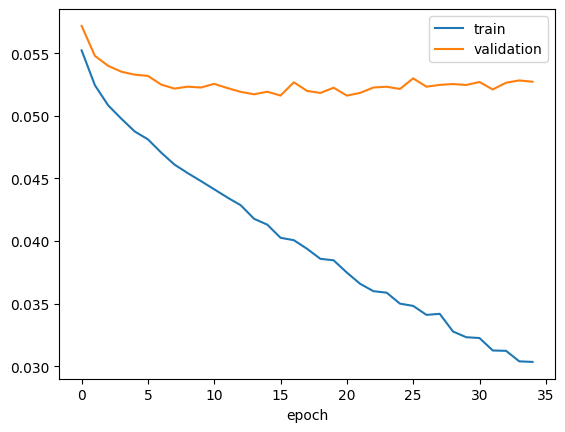

In [ ]:
mse_val, epoch, nn_model_scaled = train_net(
    X_train, y_train, X_val, y_val, True,
    do, num_epochs, batch_size, learning_rate, verbose=True, graph=True
)

df_models.loc[len(df_models)] = ['NeuroNet_scaled', mse_val]

Эпоха [5/100], Loss: 0.048560820519924164, MSE train: 0.048560822806116344, MSE validation: 0.05291000318831173
Эпоха [10/100], Loss: 0.044599130749702454, MSE train: 0.04459913312969939, MSE validation: 0.051921771598980315
Эпоха [15/100], Loss: 0.04119833931326866, MSE train: 0.04119833943811554, MSE validation: 0.05196292023702742
Эпоха [20/100], Loss: 0.037858203053474426, MSE train: 0.03785820260276349, MSE validation: 0.05218545955318603
Эпоха [25/100], Loss: 0.035527925938367844, MSE train: 0.03552792737068838, MSE validation: 0.05201102407088672
Эпоха [30/100], Loss: 0.03266502544283867, MSE train: 0.032665024505319606, MSE validation: 0.05204524017193074
Мин. RMSE на валидационной выборке: 0.0515441026499925 на эпохе 16


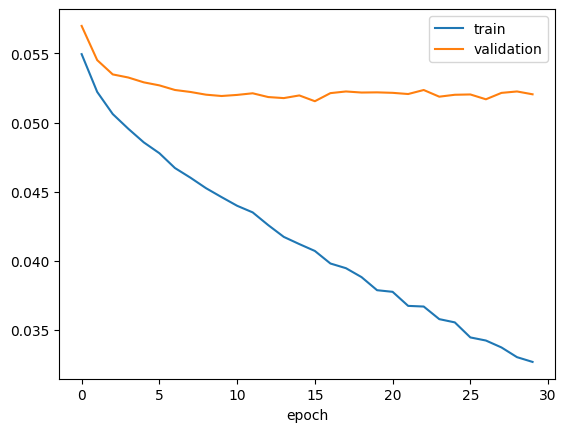

In [ ]:
mse_val, epoch, nn_model_unscaled = train_net(
    X_train, y_train, X_val, y_val, False,
    do, num_epochs, batch_size, learning_rate, verbose=True, graph=True
)

df_models.loc[len(df_models)] = ['NeuroNet_unscaled', mse_val]

In [ ]:
df_models.sort_values('mse_val')

model   mse_val
8               NeuroNet_unscaled  0.051544
7                 NeuroNet_scaled  0.051613
6          LGBMRegressor_unscaled  0.051848
5            LGBMRegressor_scaled  0.051848
0                  DummyRegressor  0.057755
3    RandomForestRegressor_scaled  0.063365
4  RandomForestRegressor_unscaled  0.063365
2       LinearRegression_unscaled  0.070414
1         LinearRegression_scaled  0.070415

In [ ]:
best_model = nn_model_unscaled

Лучший результат показала нейросеть без масштабирования признаков.

<a id="chapter_6_4"></a>
### Промежуточный вывод

В ходе построения моделей мы:
- разделили данные на тренировочную и валидационную выборки;
- провели масштабирование признаков;
- в качестве метрики использовали MSE;
- построили Dummy-модель и классические модели: линейную регрессию, регрессию на основе случайного леса и регрессию на основе Light GBM;
- построили модель на основе трехслойной нейросети;
- лучший результат на валидационной выборке показала модель на основе нейросети (MSE = 0.052).

<a id="chapter_7"></a>
## Тестирование лучшей модели

<a id="chapter_7_1"></a>
### Формирование тестовых функций

Сформируем эмбеддинги для тестовых изображений.

In [ ]:
test_image_embeddings = get_image_embeddings(df_test_images['image'], image_model, 'test_images')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def check_text(text):
    cleared_text = clear_text(text)
    if [i for i in cleared_text.split() if i in BLOCK_WORDS]:
        return cleared_text, 1
    return cleared_text, 0

In [ ]:
def find_pictures(text, top_n=1, show_true=True):
    cleared_text, block = check_text(text)
    title = 'Текст:\n' + text
    if block:
        fig = plt.figure(figsize=(10,2))
        plt.title(title)
        plt.text(0.5, 0.5, 'This image is unavailable in your country \nin compliance with local laws.',
              horizontalalignment='center', verticalalignment='center', wrap=True, fontsize=16, color='red')
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        text_embedding = get_text_embeddings(pd.Series(text), text_model, tokenizer, silent=True)
        X = np.concatenate(
            (np.resize(text_embedding, (len(test_image_embeddings),768)),
            test_image_embeddings),
            axis=1)
        X = scaler.transform(X)
        X_torch = torch.FloatTensor(X).to(device)
        best_model.eval()
        with torch.no_grad():
            predictions = best_model.forward(X_torch).flatten().cpu().numpy()

        df = pd.concat((df_test_images, pd.Series(predictions, name='prediction')), axis=1)
        top = df.sort_values(by='prediction', ascending=False)[:top_n]

        images = np.array(top['image'])
        labels = np.array(top['prediction'].round(3))

        if show_true and (df_test_queries['query_text'] == text).sum():
            idx = df_test_queries[df_test_queries['query_text'] == text].index[0]
            images = np.append(images, df_test_queries['image'][idx])
            labels = np.append(labels, 'Истинное изображение')

        show_images(images, title, labels, 'test_images')

<a id="chapter_7_2"></a>
### Проверка на описаниях из тестового набора

Выберем 20 случайных описаний из тестового набора.

In [ ]:
query_samples = list(df_test_queries['query_text'].sample(20, random_state = RANDOM_STATE))
query_samples

['A group of girls who are gothically dressed standing together',
 'A woman and girl riding downhill on a sled with a dog running alongside them',
 'The dog is running .',
 'A group of people are ice skating in a big city .',
 'Little kid in blue coat and hat riding a tricycle .',
 'Two black dogs fighting over an orange toy .',
 'A dog jumping for a tennis ball near an ocean',
 'Boy flying a distant kite .',
 'kids play ultimate Frisbee .',
 'A girl in a purple shirt feeding ducks',
 'There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground .',
 'The brown German shepherd dog is playing with a stick .',
 'a little girl blows out her candles .',
 'The little boy is smiling as he crosses a rope on an assault course .',
 'A little white dog in running on the sidewalk .',
 'two people sit on a park bench .',
 'A black dog has a dumbbell in his mouth .',
 'A boy holds a red bucket up to a pony .',
 'A group of people perform together onstage .',
 'T

Выведем по 5 "наиболее подходящих" изображений для каждого описания

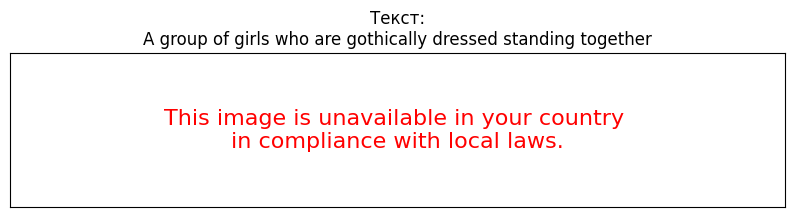

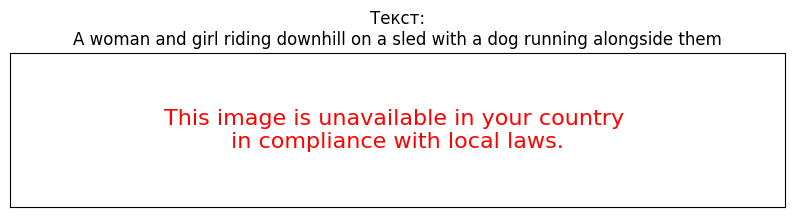

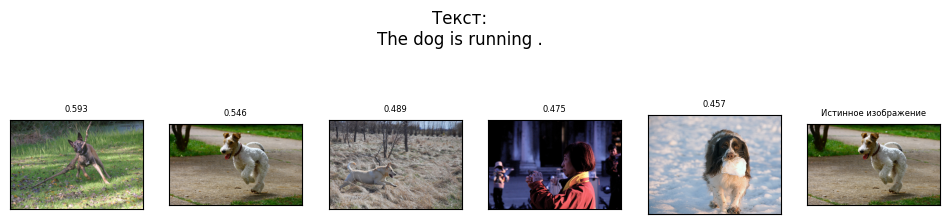

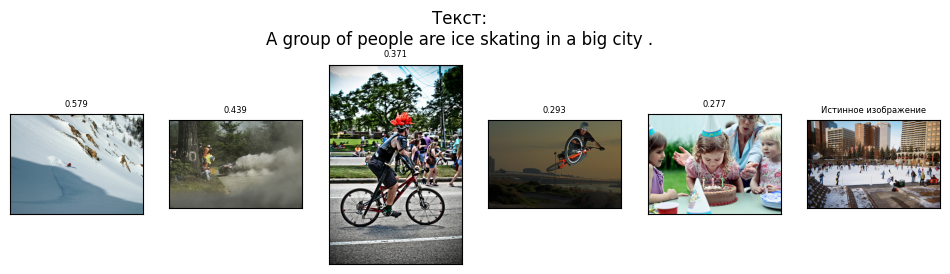

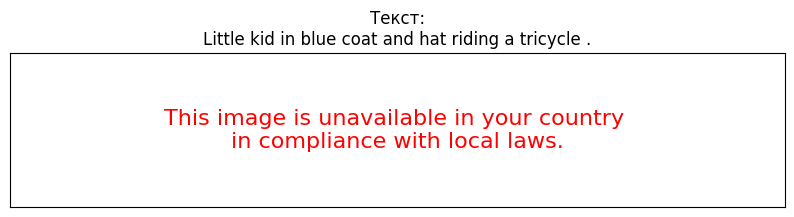

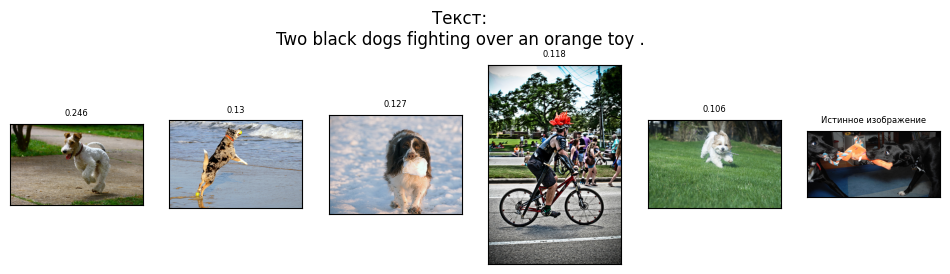

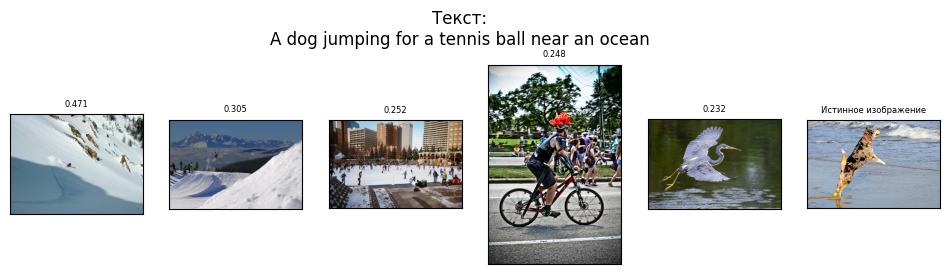

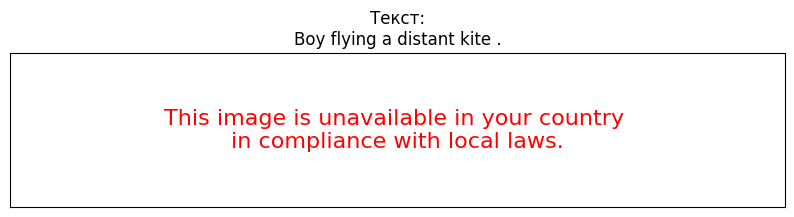

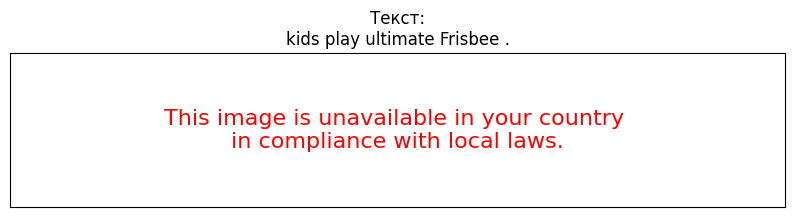

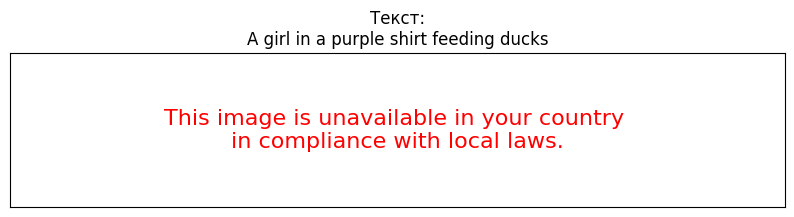

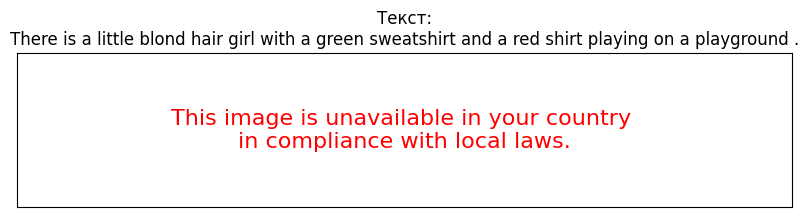

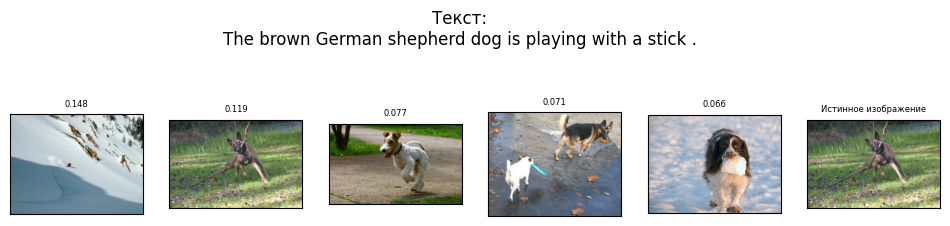

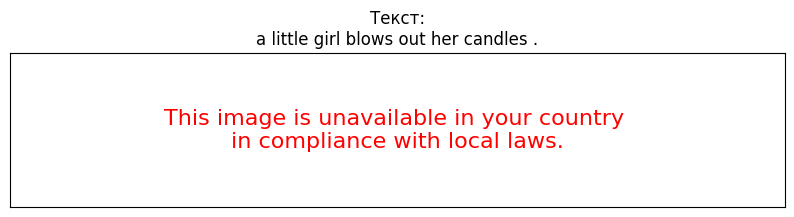

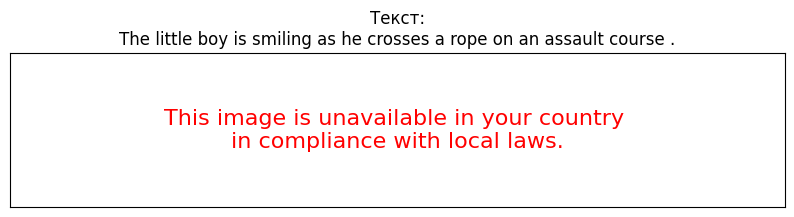

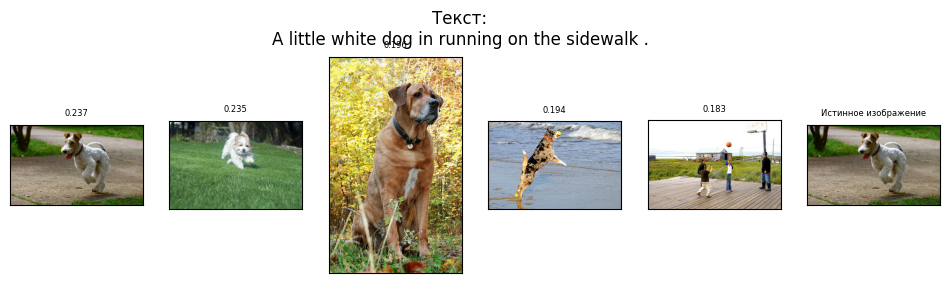

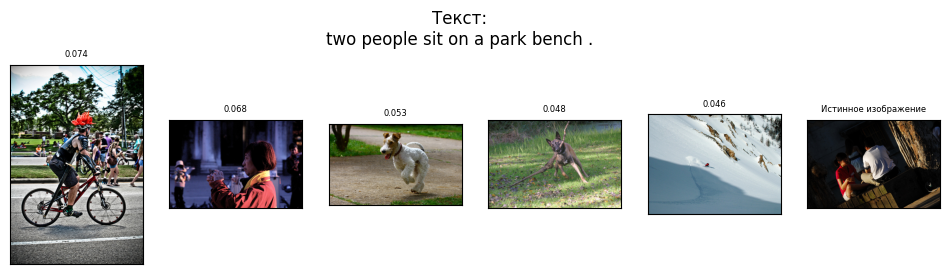

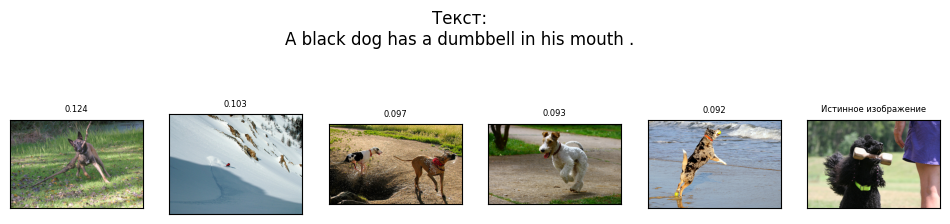

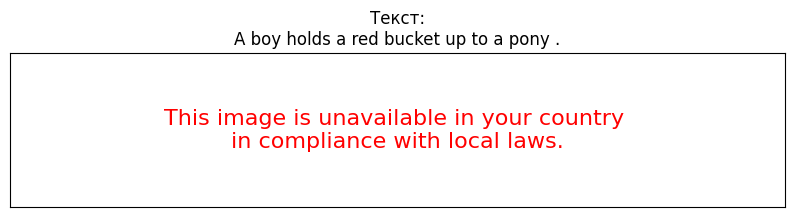

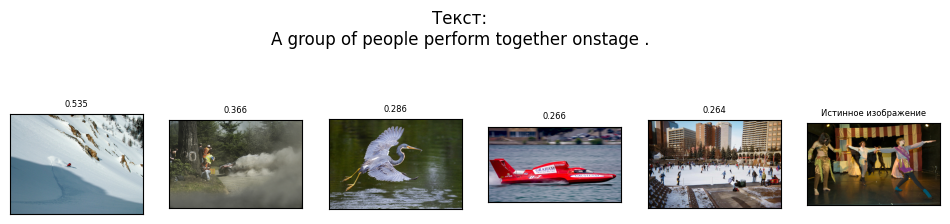

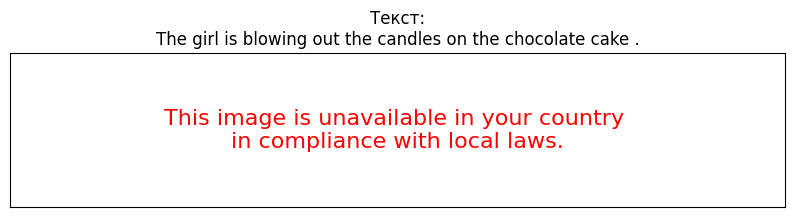

In [ ]:
for query in query_samples:
    find_pictures(query, 5)
    print

Мы видим, что наш PoC хорошо "отработал" юридические ограничения. Однако с поиском изображений справился весьма посредственно: достаточно хорошо ищет собак, даже верно нашел 3 изображения, но по другим запросам не показал даже отдаленного совпадения.

Причины неудовлетворительной работы модели могут быть в следующем:
- недостаточный объем датасета;
- дисбаланс оценок (см. выше);
- неполное соответствие использованных предобученных моделей поставленной задаче;
- недостаточная глубина модели.

Однако обучение глубокой модели заняло бы слишом много времени и ресурсов. Здесь целесообразнее воспользоваться уже предобученной моделью, созданной специально для аналогичных задач. В качестве такой модели возьмем CLIP-ViT-B-32.

<a id="chapter_7_3"></a>
### Использование предобученной модели CLIP

Модель трансформирует и текст, и изображения в общее векторное пространство. Таким образом появляется возможность оценивать сходство двух векторов для поиска семантических соответствий.

Загрузим модель.

In [ ]:
clip_model = SentenceTransformer('clip-ViT-B-32')

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

Сформируем эмбеддинги для изображений.

In [ ]:
clip_image_embeddings = clip_model.encode(
    [Image.open(PATH + 'test_images/' + img) for img in df_test_images['image']],
    convert_to_tensor=True,
    batch_size=32,
    show_progress_bar=True
)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Модифицируем функцию поиска соответствия изображений тексту с использованием семантического поиска.

In [ ]:
def find_pictures_clip(text, top_n=1, show_true=True):
    cleared_text, block = check_text(text)
    title = 'Текст:\n' + text
    if block:
        fig = plt.figure(figsize=(10,2))
        plt.title(title)
        plt.text(0.5, 0.5, 'This image is unavailable in your country \nin compliance with local laws.',
              horizontalalignment='center', verticalalignment='center', wrap=True, fontsize=16, color='red')
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        clip_text_embedding = clip_model.encode(
            [text],
            convert_to_tensor=True,
            show_progress_bar=False
        )

        top = pd.DataFrame(util.semantic_search(clip_text_embedding, clip_image_embeddings, top_k=top_n)[0])

        idx = np.array(top['corpus_id'])
        images = df_test_images['image'][idx]
        labels = np.array(top['score'].round(3))

        if show_true and (df_test_queries['query_text'] == text).sum():
            idx = df_test_queries[df_test_queries['query_text'] == text].index[0]
            images = np.append(images, df_test_queries['image'][idx])
            labels = np.append(labels, 'Истинное изображение')

        show_images(images, title, labels, 'test_images')

Проверим модель на тех же 20 описаниях.

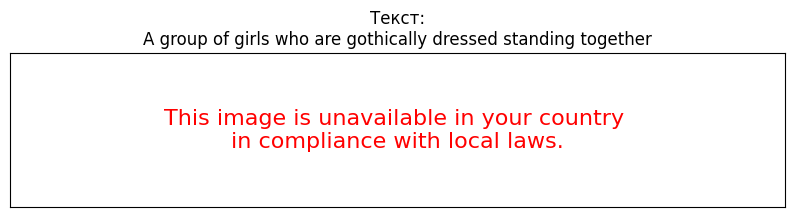

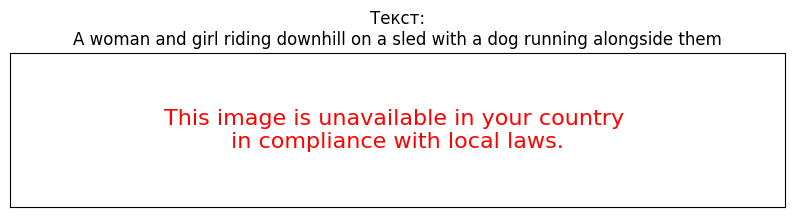

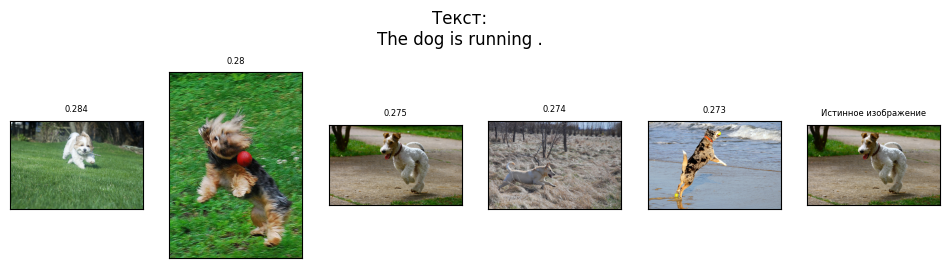

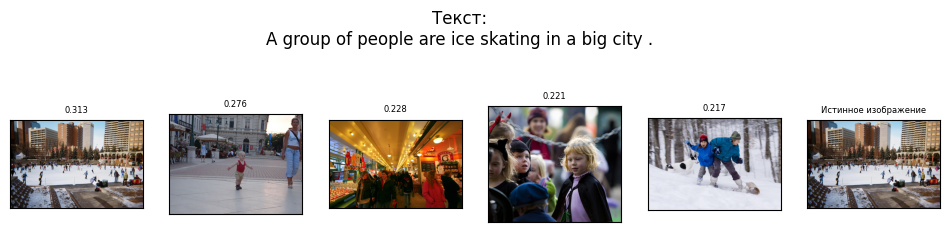

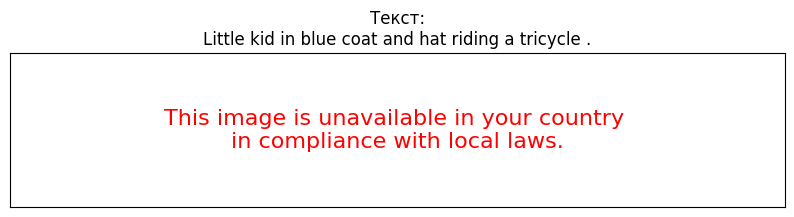

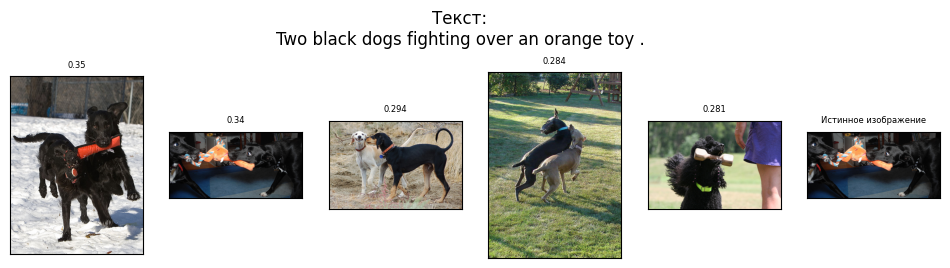

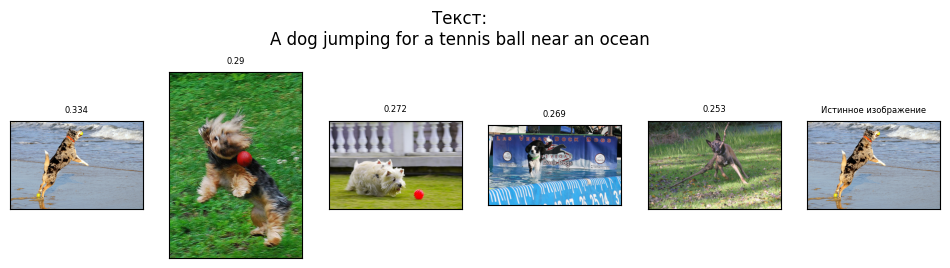

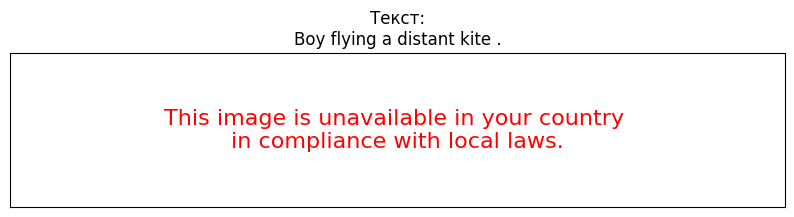

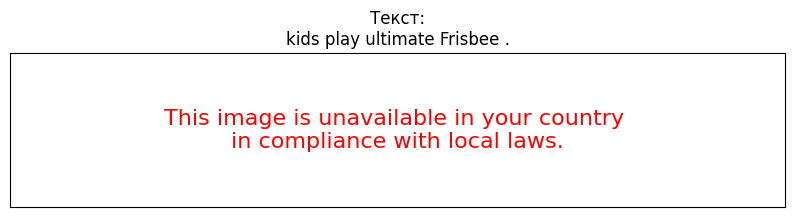

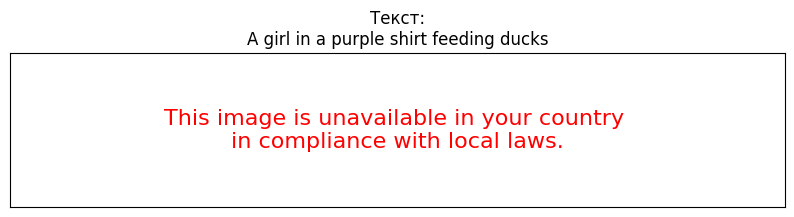

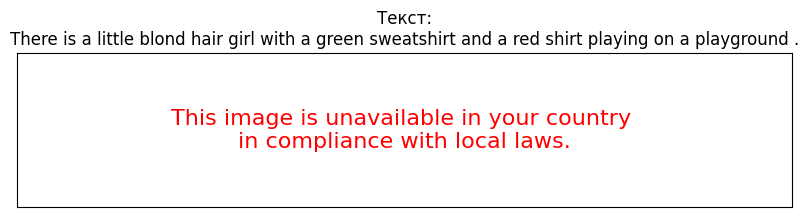

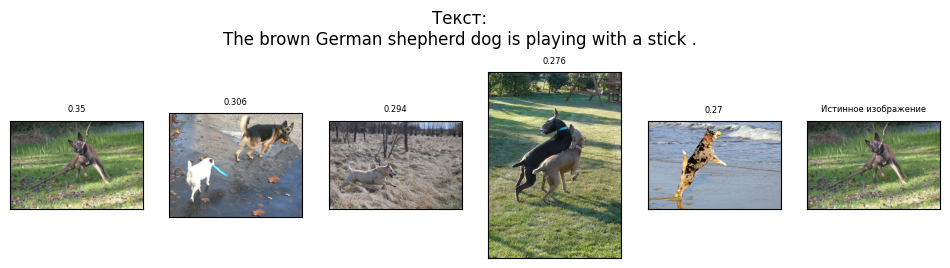

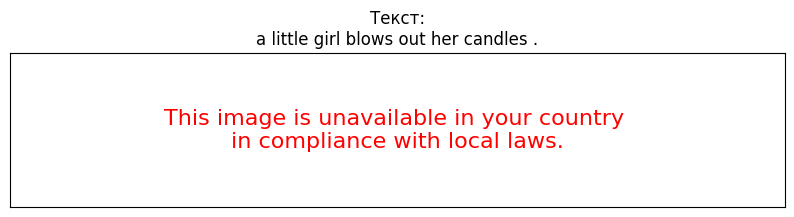

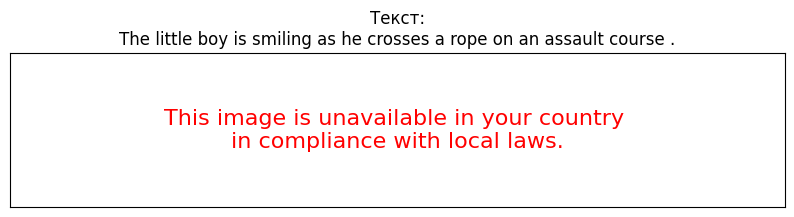

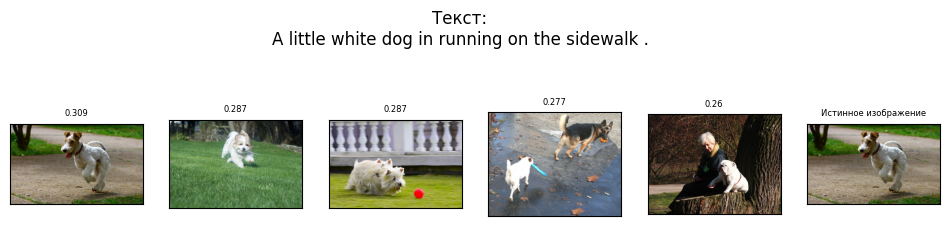

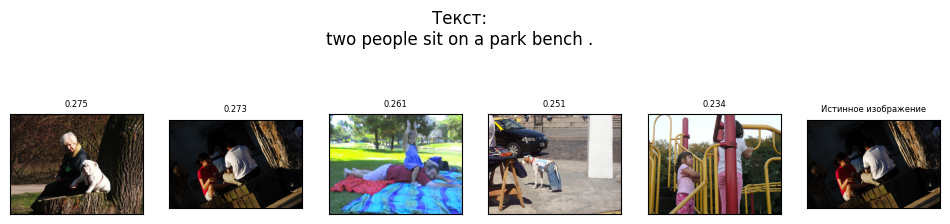

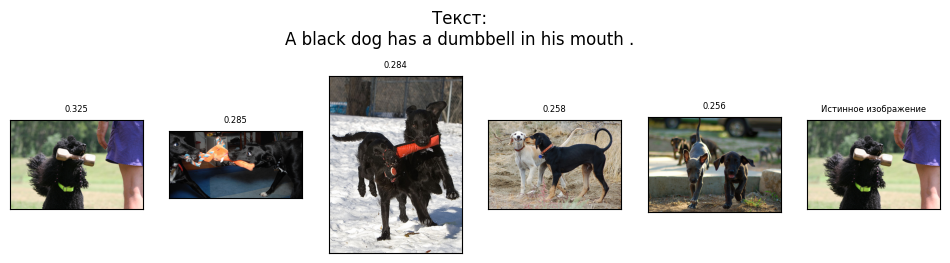

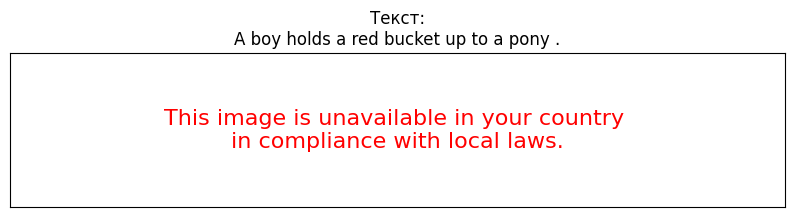

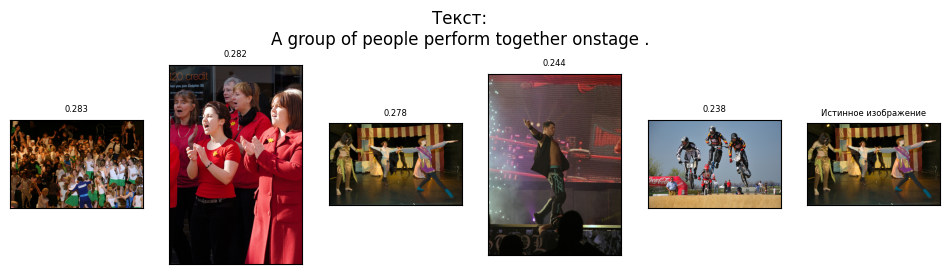

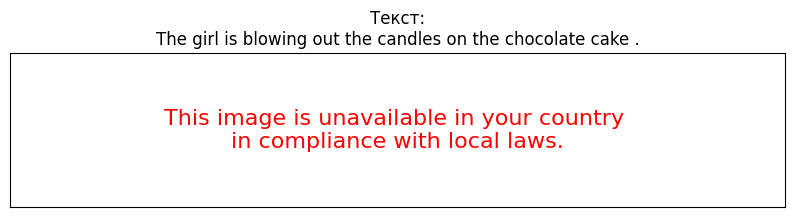

In [ ]:
for query in query_samples:
    find_pictures_clip(query, 5)
    print

Качество поиска соответствия значительно повысилось: истинное изображение есть в топ-3 выдач. А первое изображение в целом почти всегда соответствует запросу по сути.

<a id="chapter_7_4"></a>
### Промежуточный вывод

По результатам тестирования модели установлено:
- модель верно срабатывает на "стоп-слова", связанные с юридическими ограничениями;
- модель неудовлетворительно ищет изображения по описанию (но относительно неплохо ищет изображения, связанные с собаками);
- причины неудовлетворительной работы модели могут быть различными, но в данном целесообразно использовать уже специальные предобученные модели для поиска соответствия текста и изображения;
- мы использовали модель CLIP, которая трансформирует текст и изображения в единое векторное пространство;
- модель CLIP показала хорошие результаты при визуальном анализе.

<a id="chapter_8"></a>
## Общий вывод

Мы разработали PoC для поиска референсных фотографий для фотографов в соответствии с заданием заказчика.

В ходе выполнения работы мы:
1. Провели **загрузку и общий обзор данных**.
2. Провели **исследовательский анализ**, по результатам которого:
- выяснили, что оценки соответствия описаний не сбалансированы: более представлен отрицательный класс;
- выяснили, что изображения имеют разный формат;
- использовали в качестве агрегированной оценки среднюю нормализованную оценку экспертов (там, где она есть) и оценку пользователей (там, где экспертные оценки отсутствуют);
- установили, что для некоторых идентификаторов описаний отсутствовали тексты описания, и удалили такие записи.
3. Осуществили **подготовку данных**:
- удалили из обучающей выборки 303 изображения, "нарушающие" юридические правила;
- провели векторизацию текстов с использованием предобученной модели BERT;
- провели векторизацию изображений с использованием предобученной модели ResNet-18;
- объединили векторы тестов с векторами изображений.
4. Построили несколько **моделей для предсказания соответствия описания изображению**:
- разделили данные на тренировочную и валидационную выборки и провели масштабирование признаков;
- в качестве целевой метрики выбрали MSE, т.к. в данном случае мы имеем дело с задачей регрессии;
- построили Dummy-модель и классические модели: линейную регрессию, регрессию на основе случайного леса и регрессию на основе Light GBM;
- построили модель на основе трехслойной нейросети;
- лучший результат на валидационной выборке показала модель на основе нейросети (MSE = 0.052).
5. Провели **тестирование лучшей модели** на тестовом наборе и получили следующие результаты:
- запросы, содержащие "стоп-слова", связанные с юридическими ограничениями, блокируются (как того и требует ТЗ);
- модель в целом неудовлетворительно ищет изображения по описанию;
- неудовлетворительное качество модели  может быть связано с: недостаточным объемом и дисбалансом исходных данных, неполным соответствием использованных предобученных моделей поставленной задаче, недостаточной глубиной модели регрессии.
6. Использовали **предобученную модель CLIP** для поиска сответствия текста и изображения:
- сформировали эмбеддинги изображений и описания;
- использовали семантическое сходство для сравнения эмеддингов изображения и описания;
- модель CLIP показала достаточно хорошие результаты при визуальном анализе.


**Рекомендации заказчику:**
- полученный PoC на основе модели CLIP может использоваться как отправная точка для последующей разработки решения;
- при невозможности использования внешних моделей целесообразно: увеличить объем исходных данных, повысить качество оценок (например, больше экспертных оценок), снизить дисбаланс оценок, выделить дополнительные ресурсы на обучение модели.